In [1]:
#Importing the required libraries
import os         
import cv2 as cv         
import numpy as np   
import tensorflow as tf
from tensorflow.keras.models import load_model, Model     
from sklearn.cluster import KMeans                       
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image                         
import matplotlib.image as mpimg              
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score        
from tabulate import tabulate     
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [14]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Some useful function to preprocess the images and run the models  ##

In [2]:
def image_preprocessing(output_dir, 
                        df=None, 
                        path_column=None, 
                        source_dir=None, 
                        size=(500,500), 
                        brightness=None, 
                        contrast=None):
    """
    Helper function to get images either from a source directory or a list of paths contained in a df. You must specify either of the two as argument for the function to work.
    The function allows to rescale and adjust the contrast and brightness of the images before copying them to an output directory. 
    """
    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
        
    if df:
        files = list(df[path_column])       # Get file paths from a specifc column in a df
    elif source_dir:                        # Get file paths directly from a source directory
        files = []
        for file_name in os.listdir(source_dir):
            files.append(os.path.join(source_dir, file_name))
        files

    for file in files:
        image_name = str(file).split('/')[-1]
        if os.path.isfile(str(file)):
            image_array = cv.imread(file)
            img = cv.resize(image_array, size, interpolation=cv.INTER_AREA)  # Resize images using INTER_AREA as interpolation in our to avoid aliasing 

            if contrast:
                img = cv.addWeighted(img, contrast, np.zeros(image.shape, image.dtype), 0, brightness)  # adjust contrast and brightness of the image
            cv.imwrite(os.path.join(output_dir, image_name), img)
        

In [3]:
def get_files(path_to_files, size):
    """
    Helper function to load and resize images with the appropriate size for the input model. 
    """
    fn_imgs = []
    files = [file for file in os.listdir(path_to_files)]       #Storing all image files names
    for file in files:
        file_path = os.path.join(path_to_files,file)
        image_array = cv.imread(file_path)
        img = cv.resize(image_array, size, interpolation=cv.INTER_AREA) #Reading and resizing each image
        fn_imgs.append([file, img])             #Accumulating each image to a variable          
    return dict(fn_imgs)                        #Return dictionary of file names and images         

In [4]:
def feature_vector(img_arr, model):          
    if img_arr.shape[2] == 1:       
      img_arr = img_arr.repeat(3, axis=2)     #expand dimension if image is in grey scale
    arr4d = np.expand_dims(img_arr, axis=0)   #Expanding image dimension (1, 224, 224, 3) to make it a tensor compatable with keras model
    return model.predict(arr4d)[0,:]          #Returning image features through last layer of your model


#Extracting features from all the images
def feature_vectors(imgs_dict, model):
    f_vect = {}
    for fn, img in imgs_dict.items():         #For loop over each image in the imgs_dict
      f_vect[fn] = feature_vector(img, model) #Calling feature vector function to extract the features
    return f_vect                             #Returning features dictionary
     

## Load images and CNN models ##

In [ ]:
## Load single excel file
path = r''
df = pd.read_excel(path)

In [ ]:
## Concatenate multiple excel files
path = r''
df = pd.DataFrame()
for file in os.listdir(path):
    file_name = os.path.join(path, file)
    df_temp = pd.read_excel(file_name)
    df = pd.concat([df, df_temp])

In [ ]:
## Test contrast and birghtness of signle image before applying to all
file = ## put filepath of single image here
brightness=0
contrast = 1.2
image_array = cv.imread(file)
img = cv.addWeighted(image_array, contrast, np.zeros(image_array.shape, image_array.dtype), 0, brightness)
plt.imshow(img)

In [ ]:
## Get and process your images here
output_dir=, 
df=None
path_column=None 
source_dir=None 
size=(500,500) 
brightness=None
contrast=None

image_preprocessing(df=df, path_column=path_column, output_dir=output_dir)

In [5]:
## EfficientNetV2B0 Model
base_model = tf.keras.applications.EfficientNetV2B0(include_top=True,  ##input is 224,224
                                                   weights='imagenet',)
base_model.trainable = False
model = Model(inputs=base_model.input,                   
              outputs=base_model.get_layer('top_dropout').output) ## Remove last fully connected layer of the model (normally used for classification task and not useful here)

In [ ]:
## InceptionV3 Model
base_model = tf.keras.applications.InceptionV3(include_top=True,  ##input is 299,288
                                                   weights='imagenet',)
base_model.trainable = False
model = Model(inputs=base_model.input,                   
              outputs=base_model.get_layer('avg_pool').output) ## Remove last fully connected layer of the model (normally used for classification task and not useful here)

In [ ]:
## Run if you want visualize all the layers of your model ()
model.summary()

## Run CNN model ##

In [6]:
## Prepare images before feeding them to the model 
img_path = r'/Users/pietrocaprioglio/Documents/GitHub/Audio-to-spectrogram-app/pre_processed'     # Here put the output directory you used in the image_preprocessing function
imgs_dict = get_files(img_path, size = (224, 224)) # Adjust the size depending on the model you're using. Always check for input layer dimension! 

In [53]:
imgs_dict['01 Beywond.png'].shape

(224, 224, 3)

In [7]:
## Run model! 
img_feature_vector = feature_vectors(imgs_dict, model)

2025-06-22 16:35:13.088502: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 32ms/step


In [ ]:
img_feature_vector

KeyError: 0

## Now let's cluster the images based on their features using K-means ##

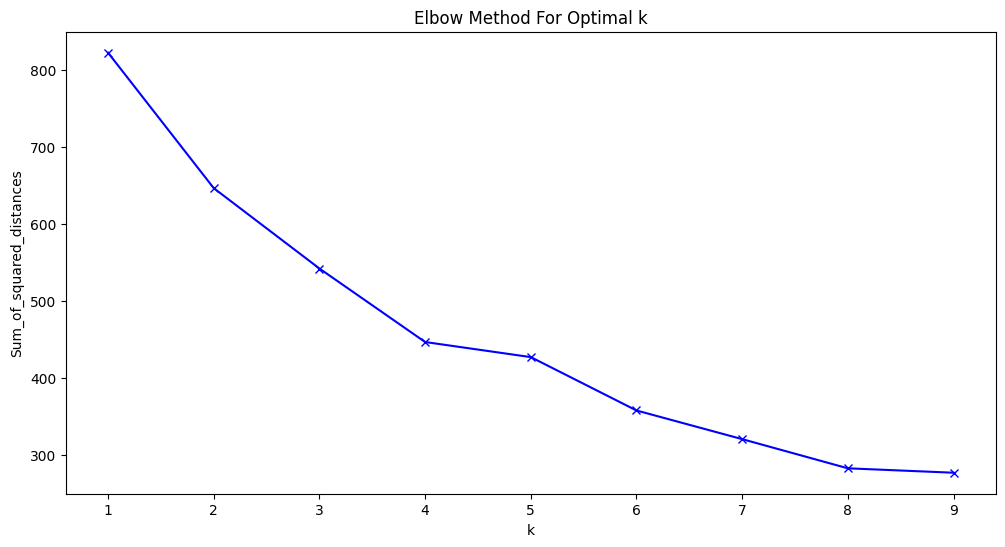

In [8]:
## Elbow plot for identify the optimal number of clusters for the K-Means algorithm 
images = list(img_feature_vector.values())    
fns = list(img_feature_vector.keys())        
sum_of_squared_distances = []                
K = range(1, 10)                              #Range of clusters to be tried
for k in K:                                  
    km = KMeans(n_clusters=k)                
    km = km.fit(images)                     
    sum_of_squared_distances.append(km.inertia_)   #Calculating the variance

#Plotting the variance
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [14]:
# Define here the output folder specific for each experiment in order to keep your results tidy.
results_path = r'/Users/pietrocaprioglio/Documents/GitHub/DL-Music-Classifier/results/EffNet_K5'
if not os.path.exists(results_path):
        os.mkdir(results_path)

In [16]:
#Running clustering algorithm with optimal number of clusters
n_clusters = 5        #put here the optimal number obtained from the elbow plot
kmeans = KMeans(n_clusters=n_clusters, init='k-means++')  
kmeans.fit(images)                    
y_kmeans = kmeans.predict(images)     
file_names = list(imgs_dict.keys())   

In [17]:
# Save an excel file with image names and cluster for any future use
data_cluster = {'File_name': file_names, 'Cluster': y_kmeans} 
df_clusters=pd.DataFrame(data_cluster)
df_clusters.to_excel(results_path+'/data_cluster.xlsx')

In [18]:
# Arrange images in different folder associated to each cluster
cluster_path = results_path     #Path to store the clusters
path_to_files = img_path        #Path to image dataset

#Creating each cluster directory
for c in range(0,n_clusters):
    if not os.path.exists(cluster_path+'/cluster_'+str(c)):
        os.mkdir(cluster_path+'/cluster_'+str(c))

#Storing each image to different clusters it belongs to 
for fn, cluster in zip(file_names, y_kmeans):
    image = cv.imread(os.path.join(img_path,fn))
    
    cv.imwrite(cluster_path+'/cluster_'+str(cluster)+'//'+fn, image)

In [ ]:
#Plotting images in each cluster
cluster_number =  #Cluster number to be plotted
fig = plt.figure(figsize=(14, 14))   
cluster_no = f'//cluster_{cluster_number}//'           
cluster_path = results_path + cluster_no  
images = [file for file in os.listdir(cluster_path)] 

for cnt, data in enumerate(images[1:30]): 
    y = fig.add_subplot(6, 5, cnt+1)      
    img = mpimg.imread(cluster_path+data) 
    y.imshow(img)                        
    plt.title(cluster_no)                
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

cluster0_imgs_total = len(images)   #check tot number of images per specified cluster

For n_clusters = 5 The average silhouette_score is : 0.08164763450622559


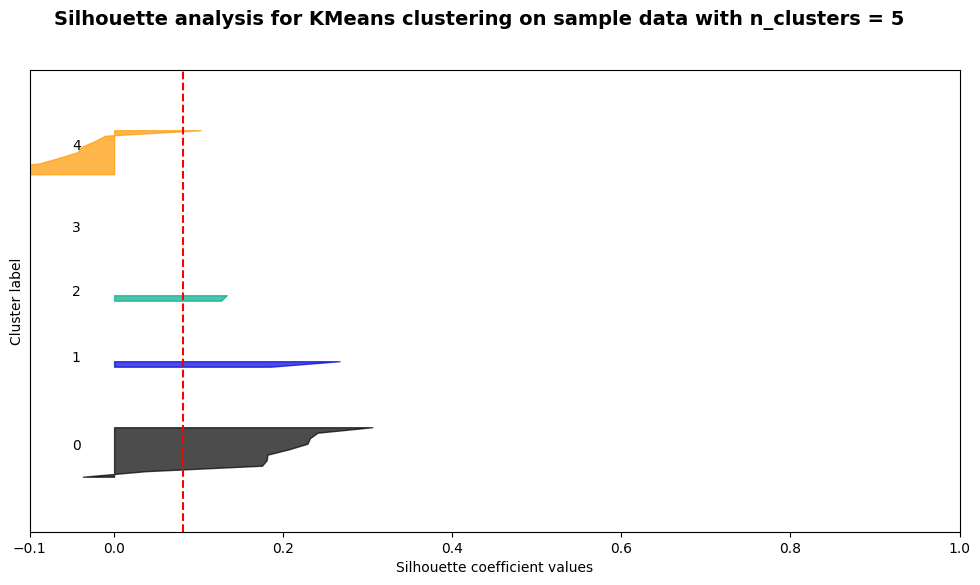

In [20]:
# Silhouette plot in order to have a more qualitative assesment of the clustering quality
images = list(img_feature_vector.values())   
fig, ax = plt.subplots(figsize=(12, 6))        
ax.set_xlim([-0.1, 0.5])                               
ax.set_ylim([0, len(images) + (n_clusters + 1) * 10])  

sample_silhouette_values = silhouette_samples(images, y_kmeans)
silhouette_avg = silhouette_score(images, y_kmeans)

y_lower = 10
#For loop over each image in the respective cluster
for i in range(n_clusters):
  # Aggregate the silhouette scores for samples belonging to
  # cluster i, and sort them
  ith_cluster_silhouette_values = \
      sample_silhouette_values[y_kmeans == i]

  ith_cluster_silhouette_values.sort() #Sorting each cluster score
  
  #Setting limit for each cluster in y-axis
  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i
  
  #Setting color for each cluster's silhouette coefficients
  color = cm.nipy_spectral(float(i) / n_clusters) 
  ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

  # Label the silhouette plots with their cluster numbers at the middle
  ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

  # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

#Titles for the plot
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])  
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold');

#Printing the average silhouette score for the clusters
print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

plt.savefig(results_path + '/silhuette.png', bbox_inches = 'tight')

## Here let's try the clustering using DBSCAN to see if we get better results depending on the experiment ##

In [21]:
# Here load DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
images = list(img_feature_vector.values())    #Image feature vectors
fns = list(img_feature_vector.keys())         #Image file names

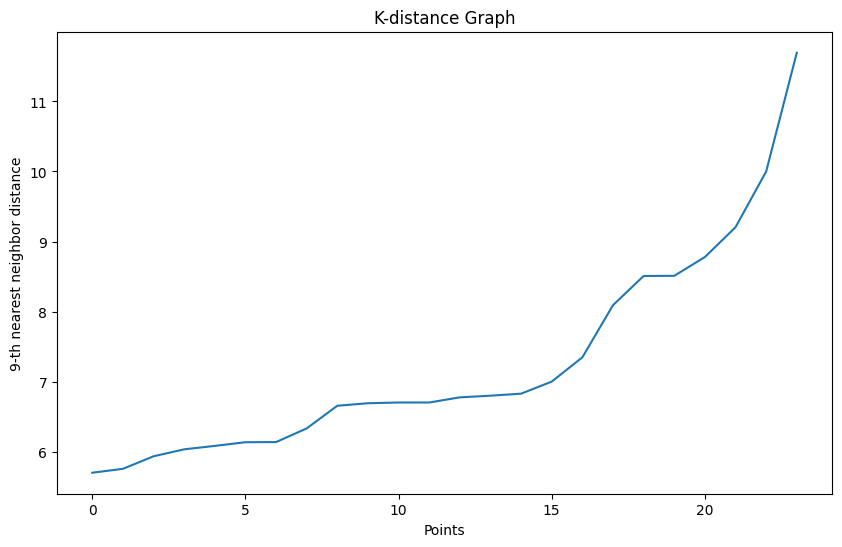

In [44]:
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.show()
# Plot k-distance graph
plot_k_distance_graph(images, k=9)

In [49]:
dbscan = DBSCAN(eps=9,
         min_samples=3)

clusters = dbscan.fit_predict(images)
y_clusters = dbscan.labels_

# results_path = r'/Users/pietrocaprioglio/Documents/GitHub/DL-Music-Classifier/results/EffNet_DBSCAN_eps8_min3'
# if not os.path.exists(results_path):
#         os.mkdir(results_path)


In [50]:
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)
print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')

Number of clusters: 1
Number of noise points: 1


In [ ]:
data_cluster = {'File_name': file_names, 'Cluster': y_clusters} 
df_clusters=pd.DataFrame(data_cluster)
df_clusters.to_excel(results_path+'/data_cluster.xlsx')

In [ ]:
cluster_path = results_path    #Path to store the clusters
path_to_files = img_path   #Path to image dataset

#Creating each cluster directory
for c in range(0,n_clusters):
    print(c)
    if not os.path.exists(cluster_path+'/cluster_'+str(c)):
        os.mkdir(cluster_path+'/cluster_'+str(c))

#Storing each image to different clusters it belongs to 
for fn, cluster in zip(file_names, y_clusters):
    image = cv2.imread(os.path.join(img_path,fn))
    
    cv2.imwrite(cluster_path+'/cluster_'+str(cluster)+'//'+fn, image)

In [ ]:
# Silhouette plot in order to have a more qualitative assesment of the clustering quality
images = list(img_feature_vector.values())   
fig, ax = plt.subplots(figsize=(12, 6))        
ax.set_xlim([-0.1, 0.5])                               
ax.set_ylim([0, len(images) + (n_clusters + 1) * 10])  

sample_silhouette_values = silhouette_samples(images, y_kmeans)
silhouette_avg = silhouette_score(images, y_kmeans)

y_lower = 10
#For loop over each image in the respective cluster
for i in range(n_clusters):
  # Aggregate the silhouette scores for samples belonging to
  # cluster i, and sort them
  ith_cluster_silhouette_values = /
      sample_silhouette_values[y_kmeans == i]

  ith_cluster_silhouette_values.sort() #Sorting each cluster score
  
  #Setting limit for each cluster in y-axis
  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i
  
  #Setting color for each cluster's silhouette coefficients
  color = cm.nipy_spectral(float(i) / n_clusters) 
  ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

  # Label the silhouette plots with their cluster numbers at the middle
  ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

  # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

#Titles for the plot
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])  
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold');

#Printing the average silhouette score for the clusters
print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

plt.savefig(results_path + '/silhuette.png', bbox_inches = 'tight')

In [ ]:
#Plotting images in each cluster
cluster_number =  #Cluster number to be plotted
fig = plt.figure(figsize=(14, 14))   
cluster_no = f'//cluster_{cluster_number}//'           
cluster_path = results_path + cluster_no  
images = [file for file in os.listdir(cluster_path)] 

for cnt, data in enumerate(images[1:30]): 
    y = fig.add_subplot(6, 5, cnt+1)      
    img = mpimg.imread(cluster_path+data) 
    y.imshow(img)                        
    plt.title(cluster_no)                
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

cluster0_imgs_total = len(images)   #check tot number of images per specified cluster